In [9]:
import numpy as np
import pandas as pd
import data_lib
import plot_lib
import decision_lib
from sklearn import cluster
import validation_lib
import transform_lib
from icecream import ic
import stats_lib

np.random.seed(200)

In [10]:
# print available data summary
_ = data_lib.explore_datasets(datafolder="../../Data",verbose=True)
print(data_lib.LABELS_LIST)

----------------------------------------------------------------------------------------------
-- The following 4 groups were found
-- They contain 40 datasets
-- The first printed entity is the key to the returned dictionary
-----------------------------------
Group: ../../Data/6P-positive-dilution-series-2-labelled/droplet-level-data/RawData
po-di-se-2-A4, files: 13                po-di-se-2-C4, files: 13                po-di-se-2-A1, files: 13
po-di-se-2-B1, files: 13                po-di-se-2-D1, files: 13                po-di-se-2-B4, files: 13
po-di-se-2-C1, files: 13                po-di-se-2-D4, files: 13                
-----------------------------------
Group: ../../Data/6P-positive-dilution-series-1-labelled/droplet-level-data/RawData
po-di-se-1-D4, files: 13                po-di-se-1-A4, files: 13                po-di-se-1-A1, files: 13
po-di-se-1-D1, files: 13                po-di-se-1-B1, files: 13                po-di-se-1-C1, files: 13
po-di-se-1-B4, files: 13         

### Get samples for negative control

In [11]:

# compute transformation on waste water
df_wa = data_lib.load_dataset(None, [
                                     #"wa-sa-A2", 
                                     #"wa-sa-B4",
                                     #"wa-sa-C4",
                                     #"wa-sa-B3",  
                                     "wa-sa-B2",
                                     "wa-sa-A5", 
                                     "wa-sa-A3",
                                     #"wa-sa-C2",
                                     #"wa-sa-C3", # Pos
                                     #"wa-sa-D3", # Zero
                                     #"wa-sa-D4", 
                                     #"wa-sa-B1", 
                                     #"wa-sa-A4",
                                     #"wa-sa-A1", 
                                     #"wa-sa-D2",
                                     #"wa-sa-C5", # Pos
                                     #"wa-sa-D5", # Zero
                                     #"wa-sa-C1",
                                     ], datafolder="../../Data")
df_negative_control = data_lib.load_dataset([],[
                                                "wa-sa-D3",
                                                "wa-sa-D5"
                                                ], datafolder="../../Data")
np_negative_control = df_negative_control.to_numpy()
np_wa = df_wa.to_numpy(copy=True)[:,:6]


In [12]:
# fix clustering algorithm
prediction_axis = ['SARS-N2_POS','SARS-N1_POS','IBV-M_POS','RSV-N_POS','IAV-M_POS','MHV_POS']
#cluster_engine = cluster.DBSCAN(eps=700, min_samples=5)
whitening_engine = transform_lib.WhitenTransformer(whiten=transform_lib.Whitenings.NONE)
num_cluster = int(2**len(prediction_axis) * 2)
cluster_engine = cluster.KMeans(n_clusters=num_cluster, n_init='auto')
decision = decision_lib.WhitnesDensityClassifier(
                                     negative_control=np_negative_control,
                                     cluster_algorithm=cluster_engine,
                                     whitening_transformer=whitening_engine,
                                     negative_range=0.2,
                                     eps=0.4,
                                     outlier_quantile=0.001,
                                     prediction_axis=prediction_axis,
                                     verbose=True
                                     )
df_decision = decision.predict(np_wa, verbose=1)

ic| sp.normaltest(np_points_no_outlier / r).statistic: array([110482.28801927, 116844.45911548,  47803.65403661,   4460.10832276,
                                                               13507.62068903,  90855.51551114])


Finished compute clusters in 0.6485815048217773 seconds
Finished compute transformed features in 0.1811079978942871 seconds


/home/nico/edu/semiv/lab/code/libs/decision_lib/whitnes_density_classifier.py:372: RuntimeWarning: overflow encountered in exp
  in_range = 1 / (1 + np.exp(scaled_avg_dist_))


Finished predict cluster labels in 0.6838507652282715 seconds
Finished predict labels in 0.038359880447387695 seconds


all_data: array([580649.61363481, 567201.03343863, 519810.41037185, 775454.94531809, 629424.8984976 , 626092.23288712])
zero_cluster: array([4552.02708072, 4057.98121764, 3611.95697644, 4519.02878668, 1311.93240028, 3594.29422528]

## Plot the predictions

- Black = True negative prediction
- Green = True positive prediciton
- Purple = False negative
- Red = False positive

#### Plot for all diseases predictions against ground truth

Firs plot is in the decorrelated coordinates, whereas the second is in original coordinates

Outlier rate: 0.0010131364299819695, n_outlier: 59

Total error rate: 0.00034966623798738267
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.001232     0.000621        0.0        0.0        0.0 0.000245

Precision (TP / (TP + FP)): 1.0
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
         1.0          1.0        0.0        0.0        0.0      1.0

Recall / TPR (TP / (TP + FN)): 1.0
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
         1.0          1.0        0.0        0.0        0.0      1.0

Specificity / TNR (TN / (TN + FP)): 1.0
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
         1.0          1.0        1.0        1.0        1.0      1.0

Accuracy ((TP + TN) / (P + N)): 1.0
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
         1.0          1.0        1.0        1.0        1.0      1.0

F1 (2 * (precision * recall) / (precision + recall)): 0.9999999999999996
 SARS-

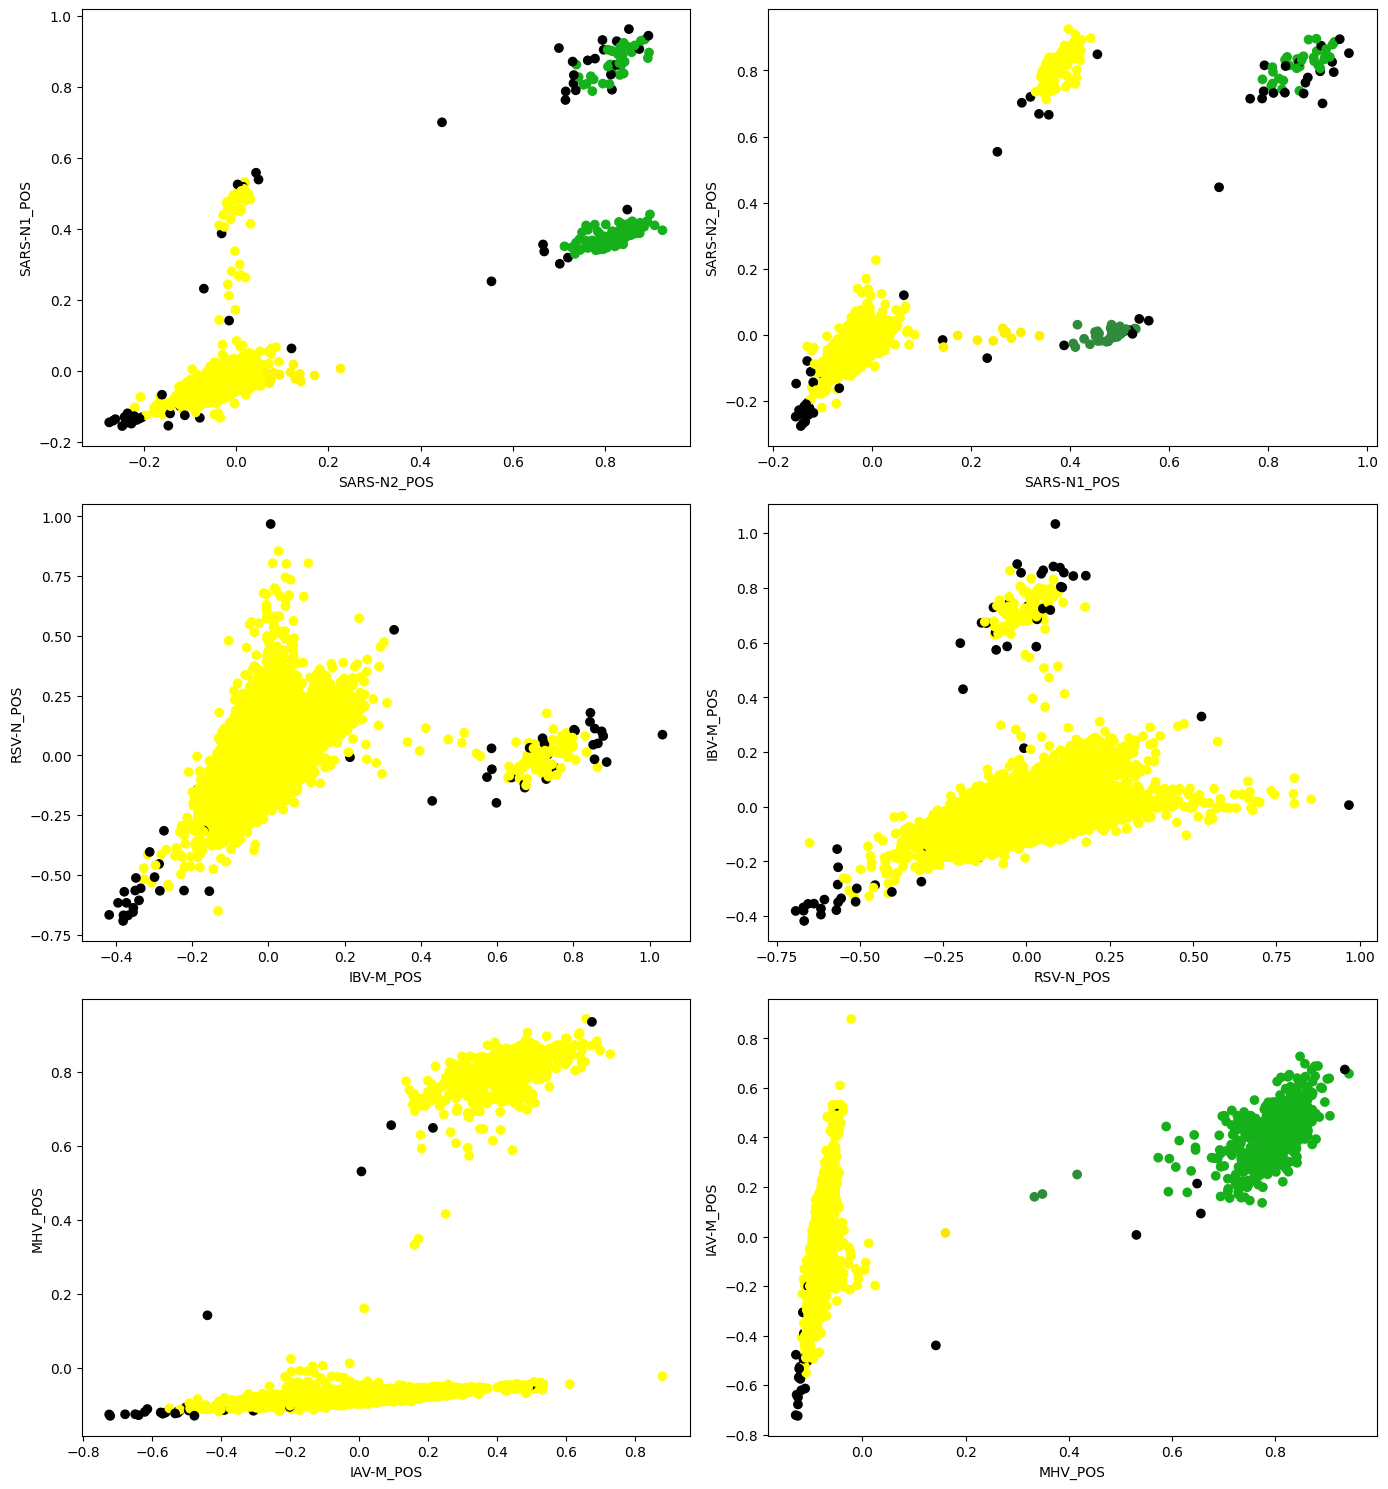

In [13]:

df_data_points = pd.DataFrame(data=decision.X_transformed, columns=prediction_axis) 
df_predictions = decision.probabilities_df
df_ground_trouth = df_wa
selected_pairs = [
                ('SARS-N2_POS','SARS-N1_POS'),
                ('SARS-N1_POS','SARS-N2_POS'),
                ('IBV-M_POS','RSV-N_POS'),
                ('RSV-N_POS','IBV-M_POS'),
                ('IAV-M_POS','MHV_POS'),
                ('MHV_POS','IAV-M_POS'),
                ]

validation_lib.validate_labels(df_ground_trouth, df_predictions, threshold=0.5)

df_result = stats_lib.compute_results(df_predictions, 0.40, 0.60, df_data_points)

plot_lib.plot_pairwise_selection_bayesian(
        df_data_points,
        df_predictions,
        df_ground_trouth,
        selected_pairs,
        n_cols=2,
        mask=decision.No_neg_mask
        )

In [14]:
df_result.to_csv("test_wa.csv")


In [15]:
validation_lib.get_negative_percent(df_ground_trouth, prediction_axis)

ic| negative_count.shape: (6,)
ic| negative_percent.shape: (6,)
ic| axis: ['SARS-N2_POS', 'SARS-N1_POS', 'IBV-M_POS', 'RSV-N_POS', 'IAV-M_POS', 'MHV_POS']
ic| all_neg.shape: ()
ic| all_neg_per.shape: ()
ic| np.var(np_points, axis=0): array([0.00246663, 0.00157731, 0.        , 0.        , 0.        ,
                                      0.00893392])


Positive count: 
   SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
0          144           92          0          0          0      525
Positive percent: 
   SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS   MHV_POS
0     0.002473      0.00158        0.0        0.0        0.0  0.009015
Negative percent: 
   SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS   MHV_POS
0     0.997527      0.99842        1.0        1.0        1.0  0.990985
All neg Count count: 
57527
All neg percent: 
0.9878423628402163
All pos percent: 
0.012157637159783685


In [16]:
decision.neg_dimensions

array([False, False,  True,  True,  True, False])